## Create a Model to find the best spot for my skate session

My goal for this project is to build the best machine learning model to help me find the best skatepark for my session, according of the week day, the weather, temperature and the traffic time.
Montréal has 14 skateparks, sometimes it's hard for me to choose the best spot.
The input will be:
 -  the weather (of course, I don't want to skate outside if it snows...)
 -  the temperature 
 -  the traffic time (Sometimes the traffic at Montréal is a nightmare)
 - I also gave a general grade for the skatepark..

## Connexion to the S3 bucket and get the data:

In [1]:
import os, boto3, random, datetime
import pandas as pd
from botocore.exceptions import ClientError
from io import StringIO
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

2025-11-18 03:05:39.975918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 03:05:39.976268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 03:05:40.018651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 03:05:41.347961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
%load_ext tensorboard
! rm -rf ./logs/

## Get Data from S3:

For the model, as it's a simple regression, we can just give as a input 1 spot index, and not the 14 skatespots.
The time to do all the inference will not be a problem, it's not a critical system.
It will be easier to me to add skateparks, Montreal build new one, in the future.

In [3]:
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("S3_ENDPOINT"),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="us-east-1"
)

In [4]:
BUCKET_NAME = "skatedata"         
FILE_KEY = "clean_skatepark_dataset.csv"  

obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

print(df.head())

     spot_name  index spot  weather  temperature  traffic_time  satisfaction
0     Ahuntsic           0        3         24.8          28.0           8.0
1     VanHorne           1        3         24.8          28.0           5.0
2       Verdun           2        3         24.8          28.0           5.0
3      Lasalle           3        3         24.8          28.0           8.0
4  Préfontaine           4        3         24.8          28.0           7.0


## Generator:


In [5]:
random.seed(1)

INPUTS_COLS = ["index spot", "weather", "temperature", "traffic_time"]
OUTPUT_COLS =  "satisfaction"
TRAINING_PERCENTAGE = 85



dataset = [
                [row[INPUTS_COLS].tolist(), row[OUTPUT_COLS]]
                for _, row in df.iterrows()
            ]
random.shuffle(dataset)

split_idx = int(TRAINING_PERCENTAGE / 100 * len(dataset))
train_dataset = dataset[:split_idx]
val_dataset = dataset[split_idx:]


import numpy as np

def generator(part_dataset, batch_size=4):
    X_batch, y_batch = [], []

    while True:
        for X, y in part_dataset:
            X_batch.append(X)
            y_batch.append(y)

            if len(X_batch) == batch_size:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
                X_batch, y_batch = [], []

        if X_batch:
            yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
            X_batch, y_batch = [], []


## Model Architecture:

First Model tested will be 5 Dense Layers.

In [19]:
INPUT_DIM = len(INPUTS_COLS)
OUTPUT_DIM = 1

model = models.Sequential([
    layers.Input(shape = (INPUT_DIM,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(OUTPUT_DIM, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='mse',            
    metrics=['mae']        
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

## Training:

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
EPOCHS = 1000
BATCHSIZE = 32

training_gen   = generator(train_dataset, BATCHSIZE)
validation_gen = generator(val_dataset, BATCHSIZE)

steps_per_epoch = len(train_dataset) // BATCHSIZE
validation_steps = len(val_dataset) // BATCHSIZE

history = model.fit(
    training_gen,
    validation_data=validation_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)


Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 59.3701 - mae: 6.6291 - val_loss: 67.9953 - val_mae: 7.2897
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 59.6438 - mae: 6.6531 - val_loss: 67.7419 - val_mae: 7.2725
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 57.7984 - mae: 6.5232 - val_loss: 67.4899 - val_mae: 7.2553
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 58.5223 - mae: 6.5780 - val_loss: 67.2391 - val_mae: 7.2381
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 57.0290 - mae: 6.4759 - val_loss: 66.9893 - val_mae: 7.2210
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 58.1044 - mae: 6.5575 - val_loss: 66.7403 - val_mae: 7.2039
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 58.3972 - mae: 6.5741 - val_loss: 66.4915 - val_mae: 7.1868
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57.8956 - mae: 6.5342 - val_loss: 66.2438 - val_mae: 7.1697
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━

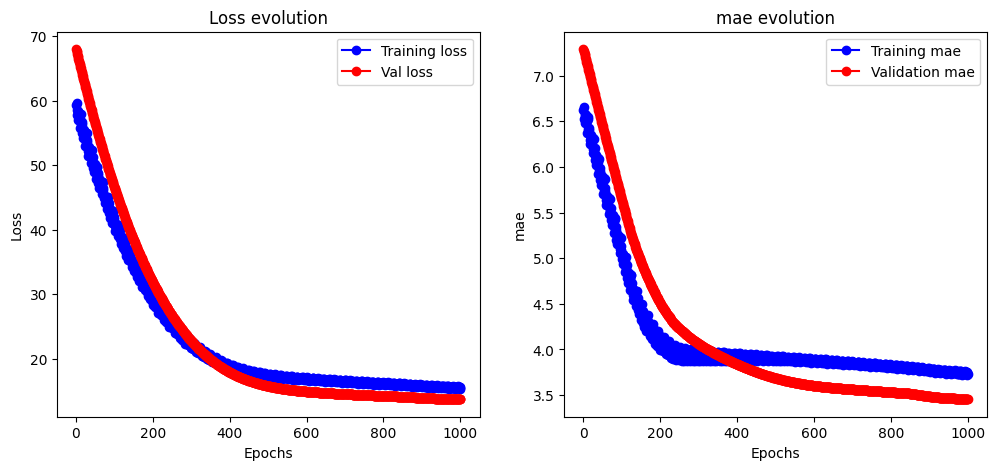

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history.get('mae')
val_mae = history.history.get('val_mae')

epochs = range(1, EPOCHS + 1)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo-', label = "Training loss")
plt.plot(epochs, val_loss, 'ro-', label = "Val loss")

plt.title("Loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae, 'bo-', label='Training mae')
plt.plot(epochs, val_mae, 'ro-', label="Validation mae")
plt.title( "mae evolution")
plt.xlabel('Epochs')
plt.ylabel("mae")
plt.legend()
plt.show()

In [10]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 64727), started 10 days, 23:37:12 ago. (Use '!kill 64727' to kill it.)

## Test and Validation:

In [16]:
skateparks_list = [
    "Ahuntsic"         , # 0
    "VanHorne"         , # 1
    "Verdun"           , # 2
    "Lasalle"          , # 3
    "Préfontaine"      , # 4
    "Boucherville"     , # 5
    "Taz"              , # 6
    "Spin"             , # 7
    "Saint Jérome"     , # 8
    "Saint Sauveur"    , # 9
    "Assomption"       , # 10
    "Benny"            , # 11
    "Dorval"           , # 12
    "Magog"            , # 13
    "Berthierville"      # 14
]

# Weather: 
# Rain or Snow  = 0
# Clouds + Wind = 1
# Clouds        = 2
# Blue sky      = 3

weather_dict = {
    0: "Rain or Snow",
    1: "Windy or heavily cloudy",
    2: "cloudy",
    3: "Blue sky"
}

## Test1: 
Sky is blue, Temperature is great, 24°C.
Everyone want to go outside. As a rare weather here in canada, or maybe it's a great day in spring, I would go outside of the city.
The Best grade should be for Magog, Berthierville, St Jerome, st Sauveur
The Worst should be Taz and Spin

In [24]:
import numpy as np


WEATHER = 3        # Sky blue
TEMP = 24.0        # great temperature 24 °C
BATCH_INPUTS = [
    28, 24, 30, 35, 15, 20, 34, 40, 50, 60, 45, 30, 30, 120, 60
]

predictions = []

for idx, traffic_time in enumerate(BATCH_INPUTS):
    input_test = [idx, WEATHER, TEMP, traffic_time]
    input_test_array = np.array([input_test])

    prediction = model.predict(input_test_array, verbose=0)[0][0]
    predictions.append((skateparks_list[idx], float(prediction)))

predictions_sorted = sorted(predictions, key=lambda x: x[1], reverse=True)

for rank, (spot, grade) in enumerate(predictions_sorted, start=1):
    print(f"{rank:2d}. {spot:<20s} → {grade:.2f}/10")


 1. Magog                → 10.10/10
 2. Berthierville        → 5.59/10
 3. Saint Sauveur        → 5.49/10
 4. Saint Jérome         → 5.14/10
 5. Assomption           → 5.10/10
 6. Spin                 → 4.94/10
 7. Taz                  → 4.84/10
 8. Benny                → 4.76/10
 9. Dorval               → 4.75/10
10. Lasalle              → 4.66/10
11. Verdun               → 4.33/10
12. Boucherville         → 4.10/10
13. Ahuntsic             → 3.85/10
14. VanHorne             → 3.76/10
15. Préfontaine          → 3.32/10


## Test2:

Weather is really bad, snow and 0°C...
Everyone is at the taz or Spin.
Nobody will skate outside...

In [25]:
import numpy as np


WEATHER = 0        # Sky blue
TEMP = 0.0        # great temperature 24 °C
BATCH_INPUTS = [
    28, 24, 30, 35, 15, 20, 34, 40, 50, 60, 45, 30, 30, 120, 60
]

predictions = []

for idx, traffic_time in enumerate(BATCH_INPUTS):
    input_test = [idx, WEATHER, TEMP, traffic_time]
    input_test_array = np.array([input_test])

    prediction = model.predict(input_test_array, verbose=0)[0][0]
    predictions.append((skateparks_list[idx], float(prediction)))

predictions_sorted = sorted(predictions, key=lambda x: x[1], reverse=True)

for rank, (spot, grade) in enumerate(predictions_sorted, start=1):
    print(f"{rank:2d}. {spot:<20s} → {grade:.2f}/10")


 1. Magog                → 10.17/10
 2. Berthierville        → 5.13/10
 3. Saint Sauveur        → 5.12/10
 4. Saint Jérome         → 4.27/10
 5. Assomption           → 3.86/10
 6. Spin                 → 3.42/10
 7. Lasalle              → 3.01/10
 8. Taz                  → 2.91/10
 9. Dorval               → 2.65/10
10. Benny                → 2.63/10
11. Verdun               → 2.59/10
12. Ahuntsic             → 2.41/10
13. VanHorne             → 2.09/10
14. Boucherville         → 1.76/10
15. Préfontaine          → 1.35/10


## Intepretation:

#### Test1:
A beautiful day, we want to go outside of the city. Coherent!
#### Test2:
Even if the good skatepark, outside of the city still get good grade, it should be the indoor skatepark the winner..

## Tensorflow Lite:

In [14]:
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open("model.tflite", 'wb') as file:
        file.write(tflite_model)
    print("[+] Great success!!!!")
except Exception as e:
    print(f"[-] {e}")    

INFO:tensorflow:Assets written to: /tmp/tmpv2smvb2g/assets


INFO:tensorflow:Assets written to: /tmp/tmpv2smvb2g/assets


Saved artifact at '/tmp/tmpv2smvb2g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  127538776177744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538776177360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538772708432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538772708816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538772708240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538772707280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538772709392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127538772709008: TensorSpec(shape=(), dtype=tf.resource, name=None)
[+] Great success!!!!


W0000 00:00:1763435215.492044    3966 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1763435215.492085    3966 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-18 03:06:55.492390: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpv2smvb2g
2025-11-18 03:06:55.492804: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-18 03:06:55.492810: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpv2smvb2g
I0000 00:00:1763435215.496206    3966 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-18 03:06:55.496825: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-18 03:06:55.519572: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpv2smvb2g
2025-11-18 03:06:55.525589: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 